# TravelSafe: Data-Driven Analysis of International Travel Safety

**Team Members:**
- Sylvan Wang (USC ID: 6176724527)
- Ningjun Li (USC ID: 5528989772)

## Project Overview

This notebook analyzes international travel safety by combining:
1. **REST Countries API** - Country demographics and geographic data
2. **Wikipedia** - Homicide rate data (web scraping)
3. **US State Department** - Travel advisory levels (from country_safety.json)

We will explore patterns, correlations, and create visualizations to understand global travel safety indicators.


## 1. Data Collection


### 0. Install Required Packages


In [49]:
# Install all required packages
%pip install requests pandas numpy matplotlib seaborn beautifulsoup4 lxml html5lib scikit-learn plotly -q pypdf

print("✓ All required packages installed successfully!")


Note: you may need to restart the kernel to use updated packages.
✓ All required packages installed successfully!


### 1.1 Import Libraries


In [50]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re
from html import unescape
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid')
    except OSError:
        plt.style.use('dark_background')
sns.set_palette("husl")
%matplotlib inline


### 1.2 Fetch REST Countries Data


In [51]:
REST_COUNTRIES_URL = (
    "https://restcountries.com/v3.1/all"
    "?fields=name,cca2,cca3,region,subregion,population,capital,languages,currencies"
)

print("Fetching REST Countries data...")
resp = requests.get(REST_COUNTRIES_URL, timeout=20)
resp.raise_for_status()
countries_data = resp.json()

# Convert to DataFrame
countries_list = []
for item in countries_data:
    code = item.get("cca2")
    if not code:
        continue
    name = item.get("name", {}).get("common", "")
    cca3 = item.get("cca3")
    countries_list.append({
        "code": code.upper(),
        "cca3": (cca3 or "").upper(),
        "name": name,
        "region": item.get("region", ""),
        "subregion": item.get("subregion", ""),
        "population": item.get("population"),
        "capital": (item.get("capital") or ["N/A"])[0],
        "languages": ", ".join(list(item.get("languages", {}).values())[:3]) if item.get("languages") else "N/A",
        "currencies": ", ".join([c["name"] for c in list(item.get("currencies", {}).values())[:2]]) if item.get("currencies") else "N/A"
    })

df_countries = pd.DataFrame(countries_list)
print(f"✓ Loaded {len(df_countries)} countries from REST Countries API")
print(f"\nSample data:")
df_countries.head()


Fetching REST Countries data...
✓ Loaded 250 countries from REST Countries API

Sample data:


,code,cca3,name,region,subregion,population,capital,languages,currencies
0,AG,ATG,Antigua and Barbuda,Americas,Caribbean,103603,Saint John's,English,Eastern Caribbean dollar
1,BT,BTN,Bhutan,Asia,Southern Asia,784043,Thimphu,Dzongkha,"Bhutanese ngultrum, Indian rupee"
2,IT,ITA,Italy,Europe,Southern Europe,58927633,Rome,"Italian, Catalan",Euro
3,TV,TUV,Tuvalu,Oceania,Polynesia,10643,Funafuti,"English, Tuvaluan","Australian dollar, Tuvaluan dollar"
4,AI,AIA,Anguilla,Americas,Caribbean,16010,The Valley,English,Eastern Caribbean dollar


### 1.3 Scrape Homicide Rate Data from Wikipedia


In [52]:
WIKIPEDIA_URL = "https://en.wikipedia.org/wiki/List_of_countries_by_intentional_homicide_rate"

print("Scraping homicide rate data from Wikipedia...")
df_homicide = None

# Set headers to avoid 403 Forbidden error
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

try:
    # Method 1: First fetch HTML with requests, then parse with pandas
    print("Fetching HTML content...")
    resp = requests.get(WIKIPEDIA_URL, timeout=30, headers=headers)
    resp.raise_for_status()
    print(f"✓ HTML fetched successfully ({len(resp.text)} characters)")
    
    # Parse all tables from the HTML
    print("Parsing tables from HTML...")
    tables = pd.read_html(resp.text)
    print(f"✓ Found {len(tables)} tables")
    
    # Find the table with homicide rate data (should have many rows and contain country/rate columns)
    for idx, table in enumerate(tables):
        cols_str = str(table.columns).lower()
        # Look for tables with country and rate columns, and should have many rows
        if len(table) > 50 and ('country' in cols_str or 'territory' in cols_str) and ('rate' in cols_str or 'homicide' in cols_str):
            df_homicide = table
            print(f"✓ Found homicide rate table (table #{idx+1}) with {len(df_homicide)} rows")
            break
    
    # If not found by criteria, try the largest table
    if df_homicide is None and len(tables) > 0:
        largest_table = max(tables, key=len)
        if len(largest_table) > 50:  # Should have many countries
            df_homicide = largest_table
            print(f"Using largest table as fallback (table with {len(df_homicide)} rows)")
    
    if df_homicide is not None and len(df_homicide) > 0:
        print(f"\n✓ Successfully loaded {len(df_homicide)} rows")
        print(f"\nColumns: {list(df_homicide.columns)}")
        print(f"\nFirst few rows:")
        display(df_homicide.head(10))
    else:
        raise ValueError("No valid tables found")
    
except Exception as e:
    print(f"Error: {e}")
    print("\nTrying alternative method with BeautifulSoup...")
    
    try:
        resp = requests.get(WIKIPEDIA_URL, timeout=30, headers=headers)
        resp.raise_for_status()
        soup = BeautifulSoup(resp.text, 'html.parser')
        
        # Find all wikitable elements
        tables_html = soup.find_all('table', class_='wikitable')
        print(f"Found {len(tables_html)} wikitable elements")
        
        # Try each table
        for idx, table_html in enumerate(tables_html):
            try:
                temp_df = pd.read_html(str(table_html))[0]
                cols_str = str(temp_df.columns).lower()
                if len(temp_df) > 50 and ('country' in cols_str or 'territory' in cols_str):
                    df_homicide = temp_df
                    print(f"✓ Found homicide rate table (wikitable #{idx+1}) with {len(df_homicide)} rows")
                    break
            except:
                continue
        
        if df_homicide is not None and len(df_homicide) > 0:
            print(f"\nColumns: {list(df_homicide.columns)}")
            display(df_homicide.head(10))
        else:
            raise ValueError("No suitable wikitable found")
            
    except Exception as e2:
        print(f"Error with BeautifulSoup method: {e2}")
        import traceback
        traceback.print_exc()
        print("Creating empty DataFrame as fallback...")
        df_homicide = pd.DataFrame()

# Ensure df_homicide is always defined
if df_homicide is None or (isinstance(df_homicide, pd.DataFrame) and len(df_homicide) == 0):
    df_homicide = pd.DataFrame()
    print("\n⚠️ Warning: Could not scrape homicide rate data. Using empty DataFrame.")
    print("The analysis will continue but without homicide rate data.")
else:
    print(f"\n✅ Successfully loaded homicide rate data for {len(df_homicide)} countries/territories")


Scraping homicide rate data from Wikipedia...
Fetching HTML content...
✓ HTML fetched successfully (329402 characters)
Parsing tables from HTML...
✓ Found 4 tables
Using largest table as fallback (table with 204 rows)

✓ Successfully loaded 204 rows

Columns: ['Location', 'Rate', 'Count', 'Year', 'Region', 'Subregion']

First few rows:


,Location,Rate,Count,Year,Region,Subregion
0,Afghanistan *,4.022,1613,2021,Asia,Southern Asia
1,Albania *,1.387,39,2023,Europe,Southern Europe
2,Algeria,1.161,536,2023,Africa,Northern Africa
3,American Samoa,0.000,0,2019,Oceania,Polynesia
4,Andorra,2.574,2,2020,Europe,Southern Europe
5,Angola,4.102,1196,2016,Africa,Sub-Saharan Africa
6,Anguilla,28.328,4,2014,Americas,Latin America and the Caribbean
7,Antigua and Barbuda *,10.665,10,2022,Americas,Latin America and the Caribbean
8,Argentina *,4.309,1961,2022,Americas,Latin America and the Caribbean
9,Armenia *,2.186,61,2021,Asia,Western Asia



✅ Successfully loaded homicide rate data for 204 countries/territories


### 1.4 Clean and Standardize Homicide Rate Data


In [53]:
# Clean homicide rate data
# Check if df_homicide exists and is not empty
if 'df_homicide' not in globals() or df_homicide is None or len(df_homicide) == 0:
    print("Warning: df_homicide is empty or not defined. Creating empty DataFrame.")
    df_homicide_clean = pd.DataFrame(columns=['country_clean', 'homicide_rate'])
else:
    # The exact column names may vary, so we'll need to inspect and adjust
    print("Original columns:")
    print(df_homicide.columns.tolist())

    # Standardize column names (adjust based on actual Wikipedia table structure)
    # Common patterns: Country/Territory, Rate, Year, etc.
    if len(df_homicide.columns) > 0 and 'Country' in str(df_homicide.columns[0]):
        df_homicide = df_homicide.rename(columns={df_homicide.columns[0]: 'country'})

    # Find rate column (usually contains numbers and may have "Rate" or "per 100,000")
    rate_col = None
    for col in df_homicide.columns:
        if 'rate' in str(col).lower() or 'per 100' in str(col).lower() or df_homicide[col].dtype in [np.float64, np.int64]:
            if df_homicide[col].dtype in [np.float64, np.int64] or any(isinstance(x, (int, float)) for x in df_homicide[col].dropna().head(5) if pd.notna(x)):
                rate_col = col
                break

    if rate_col:
        df_homicide['homicide_rate'] = pd.to_numeric(df_homicide[rate_col], errors='coerce')
    else:
        # Fallback: use first numeric column
        numeric_cols = df_homicide.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            df_homicide['homicide_rate'] = df_homicide[numeric_cols[0]]
        else:
            df_homicide['homicide_rate'] = np.nan

    # Clean country names
    if len(df_homicide.columns) > 0:
        df_homicide['country_clean'] = df_homicide.iloc[:, 0].astype(str).str.strip()
    else:
        df_homicide['country_clean'] = ''

    # Remove rows with missing homicide rate
    df_homicide_clean = df_homicide[df_homicide['homicide_rate'].notna()].copy()

    # Mark suspicious zeros (common for microstates/territories where Count==0)
    # We keep the raw rate, but create a "used" rate that treats these as missing for cross-country comparison.
    df_homicide_clean['homicide_rate_used'] = df_homicide_clean['homicide_rate']
    if 'Count' in df_homicide_clean.columns:
        count_num = pd.to_numeric(df_homicide_clean['Count'], errors='coerce')
        suspicious_zero = (df_homicide_clean['homicide_rate'] == 0) & (count_num.fillna(-1) == 0)
        df_homicide_clean.loc[suspicious_zero, 'homicide_rate_used'] = np.nan
        print(f"\n⚠️ Marked {int(suspicious_zero.sum())} records as suspicious zeros (Rate=0 & Count=0) -> homicide_rate_used = NaN")

    print(f"\n✓ Cleaned data: {len(df_homicide_clean)} countries with valid homicide rates")
    if len(df_homicide_clean) > 0:
        print(f"\nSample cleaned data:")
        cols_to_show = ['country_clean', 'homicide_rate', 'homicide_rate_used']
        cols_to_show = [c for c in cols_to_show if c in df_homicide_clean.columns]
        display(df_homicide_clean[cols_to_show].head(10))
    else:
        print("No valid homicide rate data found.")


Original columns:
['Location', 'Rate', 'Count', 'Year', 'Region', 'Subregion']

⚠️ Marked 8 records as suspicious zeros (Rate=0 & Count=0) -> homicide_rate_used = NaN

✓ Cleaned data: 204 countries with valid homicide rates

Sample cleaned data:


,country_clean,homicide_rate,homicide_rate_used
0,Afghanistan *,4.022,4.022
1,Albania *,1.387,1.387
2,Algeria,1.161,1.161
3,American Samoa,0.000,NaN
4,Andorra,2.574,2.574
5,Angola,4.102,4.102
6,Anguilla,28.328,28.328
7,Antigua and Barbuda *,10.665,10.665
8,Argentina *,4.309,4.309
9,Armenia *,2.186,2.186


### 1.5 Data Quality Check and Summary


In [54]:
# Analyze the scraped homicide rate data
print("=" * 60)
print("HOMICIDE RATE DATA ANALYSIS")
print("=" * 60)

if 'df_homicide' in globals() and df_homicide is not None and len(df_homicide) > 0:
    print(f"\n📊 Dataset Overview:")
    print(f"   Total records: {len(df_homicide)}")
    print(f"   Columns: {list(df_homicide.columns)}")
    
    # Check data types
    print(f"\n📋 Data Types:")
    print(df_homicide.dtypes)
    
    # Check for missing values
    print(f"\n🔍 Missing Values:")
    missing = df_homicide.isnull().sum()
    print(missing[missing > 0])
    
    # Basic statistics for Rate column
    if 'Rate' in df_homicide.columns:
        print(f"\n📈 Homicide Rate Statistics (per 100,000):")
        print(df_homicide['Rate'].describe())
        
        # Check year distribution
        if 'Year' in df_homicide.columns:
            print(f"\n📅 Year Distribution:")
            print(df_homicide['Year'].value_counts().head(10))
        
        # Regional distribution
        if 'Region' in df_homicide.columns:
            print(f"\n🌍 Regional Distribution:")
            region_counts = df_homicide['Region'].value_counts()
            print(region_counts)
            
            print(f"\n📊 Average Homicide Rate by Region:")

            # Unweighted (each country/territory counts equally)
            region_avg_unweighted = df_homicide.groupby('Region')['Rate'].agg(['mean', 'median', 'count']).round(2)
            region_avg_unweighted.columns = ['Mean Rate (Unweighted)', 'Median Rate', 'Count']

            # Population-weighted mean using REST Countries population
            def _norm_name_for_join(x):
                if pd.isna(x):
                    return ''
                x = str(x).strip().lower()
                x = re.sub(r'\s*\(.*?\)', '', x)
                x = re.sub(r'^the\s+', '', x)
                # Remove common unicode footnote markers like '*', '†', etc.
                x = re.sub(r'[\*†‡•]+', '', x)
                return x.strip()

            df_hom_pop = df_homicide[['Location', 'Region', 'Rate']].copy()
            df_hom_pop['name_norm'] = df_hom_pop['Location'].apply(_norm_name_for_join)

            df_pop = df_countries[['name', 'population']].copy()
            df_pop['name_norm'] = df_pop['name'].apply(_norm_name_for_join)
            df_pop['population'] = pd.to_numeric(df_pop['population'], errors='coerce')

            df_hom_pop = df_hom_pop.merge(df_pop[['name_norm', 'population']], on='name_norm', how='left')
            df_hom_pop['Rate'] = pd.to_numeric(df_hom_pop['Rate'], errors='coerce')

            def _weighted_mean_rate(g):
                g = g.dropna(subset=['Rate', 'population'])
                if g.empty or g['population'].sum() <= 0:
                    return np.nan
                return float((g['Rate'] * g['population']).sum() / g['population'].sum())

            region_weighted = (
                df_hom_pop.groupby('Region')
                .apply(_weighted_mean_rate)
                .rename('Mean Rate (Pop-weighted)')
                .to_frame()
                .round(2)
            )

            # Combine
            region_avg = region_avg_unweighted.join(region_weighted, how='left')
            # Sort by population-weighted mean when available; fallback to unweighted
            sort_col = 'Mean Rate (Pop-weighted)' if 'Mean Rate (Pop-weighted)' in region_avg.columns else 'Mean Rate (Unweighted)'
            print(region_avg.sort_values(sort_col, ascending=False))

            missing_pop = int(df_hom_pop['population'].isna().sum())
            print(
                f"\nNote: Pop-weighted mean uses REST Countries population matched by normalized name. "
                f"Unmatched populations: {missing_pop} / {len(df_hom_pop)} records (excluded from weighting)."
            )
    
    # Top and bottom countries
    if 'Rate' in df_homicide.columns and 'Location' in df_homicide.columns:
        # Note: Extremely high rates often occur for small-population territories.
        # Showing Count/Year helps interpret whether a high rate is driven by a small denominator.
        print(f"\n🔝 Top 10 Countries by Homicide Rate:")

        show_cols = ['Location', 'Rate', 'Count', 'Year', 'Region']
        show_cols = [c for c in show_cols if c in df_homicide.columns]

        top_10 = df_homicide.nlargest(10, 'Rate')[show_cols].copy()
        if 'Count' in top_10.columns:
            top_10['Count'] = pd.to_numeric(top_10['Count'], errors='coerce')
        if 'Rate' in top_10.columns:
            top_10['Rate'] = pd.to_numeric(top_10['Rate'], errors='coerce')

        # Rough implied population (only when Count & Rate exist): pop ≈ Count / Rate * 100000
        if 'Count' in top_10.columns and 'Rate' in top_10.columns:
            top_10['Implied Pop (approx)'] = (top_10['Count'] / top_10['Rate'] * 100000).round(0)

        print(top_10.to_string(index=False))

        print(
            "\nNote: Rates are per 100,000 population. Very small places can show very high rates "
            "if a modest number of cases occurs in a single year. Use Count/Year to interpret spikes."
        )

        print(f"\n🔻 Bottom 10 Countries by Homicide Rate:")
        bottom_10 = df_homicide.nsmallest(10, 'Rate')[show_cols].copy()
        if 'Count' in bottom_10.columns:
            bottom_10['Count'] = pd.to_numeric(bottom_10['Count'], errors='coerce')
        if 'Rate' in bottom_10.columns:
            bottom_10['Rate'] = pd.to_numeric(bottom_10['Rate'], errors='coerce')
        if 'Count' in bottom_10.columns and 'Rate' in bottom_10.columns:
            bottom_10['Implied Pop (approx)'] = (bottom_10['Count'] / bottom_10['Rate'] * 100000).round(0)

        print(bottom_10.to_string(index=False))
    
    # Display sample data
    print(f"\n📋 Sample Data (First 5 rows):")
    display(df_homicide.head())
    
else:
    print("⚠️ No homicide rate data available for analysis.")


HOMICIDE RATE DATA ANALYSIS

📊 Dataset Overview:
   Total records: 204
   Columns: ['Location', 'Rate', 'Count', 'Year', 'Region', 'Subregion', 'homicide_rate', 'country_clean']

📋 Data Types:
Location          object
Rate             float64
Count              int64
Year               int64
Region            object
Subregion         object
homicide_rate    float64
country_clean     object
dtype: object

🔍 Missing Values:
Series([], dtype: int64)

📈 Homicide Rate Statistics (per 100,000):
count    204.000000
mean       7.193922
std       11.291211
min        0.000000
25%        0.986500
50%        2.601000
75%        7.195500
max       76.582000
Name: Rate, dtype: float64

📅 Year Distribution:
Year
2023    55
2022    45
2021    20
2020    18
2019    13
2012     9
2009     7
2016     6
2011     6
2013     4
Name: count, dtype: int64

🌍 Regional Distribution:
Region
Americas    51
Asia        49
Europe      49
Africa      37
Oceania     18
Name: count, dtype: int64

📊 Average Homicide Ra

,Location,Rate,Count,Year,Region,Subregion,homicide_rate,country_clean
0,Afghanistan *,4.022,1613,2021,Asia,Southern Asia,4.022,Afghanistan *
1,Albania *,1.387,39,2023,Europe,Southern Europe,1.387,Albania *
2,Algeria,1.161,536,2023,Africa,Northern Africa,1.161,Algeria
3,American Samoa,0.000,0,2019,Oceania,Polynesia,0.000,American Samoa
4,Andorra,2.574,2,2020,Europe,Southern Europe,2.574,Andorra


### 1.6 Load Global Peace Index (GPI) 2025 (IEP) from PDF


In [55]:
# Load Global Peace Index (GPI) 2025 overall scores
# Preferred: use cached CSV (no extra dependencies)
# Fallback: parse the official PDF (requires pypdf)

print("Loading Global Peace Index (GPI) 2025...")

from pathlib import Path
import re
import sys
import subprocess

pdf_path = Path('Global-Peace-Index-2025-web.pdf')
cache_path = Path('gpi_2025_extracted.csv')


def load_gpi_from_cache(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    df = df.rename(columns={
        'country_gpi': 'country_gpi',
        'gpi_score': 'gpi_score',
        'gpi_rank': 'gpi_rank',
    })
    df['gpi_score'] = pd.to_numeric(df.get('gpi_score'), errors='coerce')
    df['gpi_rank'] = pd.to_numeric(df.get('gpi_rank'), errors='coerce')
    df = df.dropna(subset=['country_gpi', 'gpi_score']).drop_duplicates(subset=['country_gpi']).copy()
    return df


def ensure_pypdf():
    try:
        from pypdf import PdfReader  # noqa: F401
        return
    except Exception:
        pass

    print("Installing 'pypdf' into the current Jupyter kernel environment...")
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'pypdf==5.1.0'])


def load_gpi_2025_scores_from_pdf(pdf_file: Path) -> pd.DataFrame:
    ensure_pypdf()
    from pypdf import PdfReader

    score_token_re = re.compile(r"^\d\.\d{3}$")
    rank_token_re = re.compile(r"^=?\d{1,3}$")

    reader = PdfReader(str(pdf_file))

    # Find the main ranking table pages (header page + previous page)
    header_pages = []
    for i, page in enumerate(reader.pages):
        t = page.extract_text() or ""
        if "RANK COUNTRY SCORE CHANGE" in t:
            header_pages.append(i)

    if not header_pages:
        raise RuntimeError("Could not locate the ranking table header in the PDF.")

    pages_to_parse = sorted(set(header_pages + [p - 1 for p in header_pages if p > 0]))

    rows = []
    for i in pages_to_parse:
        text = reader.pages[i].extract_text() or ""
        tokens = " ".join(text.replace("\n", " ").split()).split()

        j = 0
        while j < len(tokens):
            tok = tokens[j]
            if not rank_token_re.match(tok):
                j += 1
                continue

            rank = int(tok.lstrip("="))
            j += 1

            country_parts = []
            while j < len(tokens) and not score_token_re.match(tokens[j]):
                if rank_token_re.match(tokens[j]) and country_parts:
                    break
                country_parts.append(tokens[j])
                j += 1

            if j >= len(tokens) or not score_token_re.match(tokens[j]):
                continue

            score = float(tokens[j])
            j += 1

            country = " ".join(country_parts).strip()
            country = country.replace("Y emen", "Yemen")
            country = re.sub(r"\s+", " ", country).strip()
            if country and country.upper() != "COUNTRY":
                rows.append({"country_gpi": country, "gpi_score": score, "gpi_rank": rank})

            # Consume change tokens so trailing numbers (e.g., UP-LONG 2) aren't mistaken as new ranks
            if j < len(tokens):
                change_tok = tokens[j]
                if change_tok in {"↔", "UP-LONG", "DOWN-LONG", "UP", "DOWN", "NEW"}:
                    j += 1
                    if change_tok in {"UP-LONG", "DOWN-LONG", "UP", "DOWN"} and j < len(tokens) and rank_token_re.match(tokens[j]):
                        j += 1

    df = pd.DataFrame(rows).drop_duplicates(subset=['country_gpi']).copy()
    if df['country_gpi'].nunique() < 150:
        raise RuntimeError(f"GPI extraction seems incomplete: {df['country_gpi'].nunique()} countries")

    # write cache for next runs
    try:
        df.to_csv(cache_path, index=False)
    except Exception:
        pass

    return df


if cache_path.exists():
    df_gpi_clean = load_gpi_from_cache(cache_path)
    print(f"✓ Loaded GPI data from cache: {len(df_gpi_clean)} countries")
    display(df_gpi_clean.head())
elif pdf_path.exists():
    df_gpi_clean = load_gpi_2025_scores_from_pdf(pdf_path)
    df_gpi_clean['gpi_score'] = pd.to_numeric(df_gpi_clean['gpi_score'], errors='coerce')
    print(f"✓ Loaded GPI data from PDF: {len(df_gpi_clean)} countries")
    display(df_gpi_clean.head())
else:
    print(f"⚠️ GPI PDF not found: {pdf_path.resolve()}")
    df_gpi_clean = pd.DataFrame(columns=['country_gpi', 'gpi_score', 'gpi_rank'])


Loading Global Peace Index (GPI) 2025...
✓ Loaded GPI data from cache: 163 countries


,country_gpi,gpi_score,gpi_rank
0,Iceland,1.095,1
1,Ireland,1.260,2
2,New Zealand,1.282,3
3,Austria,1.294,4
4,Switzerland,1.294,5


### 1.5 Load Travel Safety Data (from build_country_safety.py output)


In [56]:
# Load the country_safety.json file generated by build_country_safety.py
print("Loading safety data...")

# 1. Load detailed safety scores from JSON
try:
    with open('country_safety.json', 'r', encoding='utf-8') as f:
        safety_data = json.load(f)

    # Convert to DataFrame
    safety_list = []
    for code, data in safety_data.items():
        risk_scores = data.get('risk_scores', {})
        safety_list.append({
            'code': code,
            'name_safety': data.get('name', ''),
            'region_safety': data.get('region', ''),
            'overall_risk': data.get('overall_risk', 'unknown'),
            'crime_score': risk_scores.get('crime', 3),
            'political_score': risk_scores.get('political', 3),
            'health_score': risk_scores.get('health', 3),
            'natural_disaster_score': risk_scores.get('natural_disaster', 3),
            'is_core_country': data.get('is_core_country', False)
        })

    df_safety = pd.DataFrame(safety_list)
    print(f"✓ Loaded detailed safety scores for {len(df_safety)} countries")
except FileNotFoundError:
    print("⚠️ country_safety.json not found.")
    df_safety = pd.DataFrame()

# 2. Load US Advisory Levels (Manual/CSV)
try:
    df_advisory = pd.read_csv('us_advisories_manual.csv')
    # Ensure columns exist
    if 'country_code' in df_advisory.columns:
        df_advisory = df_advisory.rename(columns={'country_code': 'code'})
    
    if 'code' in df_advisory.columns and 'advisory_level' in df_advisory.columns:
        df_advisory = df_advisory[['code', 'advisory_level']]
        print(f"✓ Loaded US Advisory levels for {len(df_advisory)} countries")
    else:
        print("⚠️ us_advisories_manual.csv missing required columns.")
        df_advisory = pd.DataFrame(columns=['code', 'advisory_level'])
except FileNotFoundError:
    print("⚠️ us_advisories_manual.csv not found.")
    df_advisory = pd.DataFrame(columns=['code', 'advisory_level'])

if not df_safety.empty:
    display(df_safety.head())


Loading safety data...
✓ Loaded detailed safety scores for 250 countries
✓ Loaded US Advisory levels for 26 countries


,code,name_safety,region_safety,overall_risk,crime_score,political_score,health_score,natural_disaster_score,is_core_country
0,SY,Syria,Asia,high,4,4,3,3,False
1,NZ,New Zealand,Oceania,low,2,2,2,2,True
2,BN,Brunei,Asia,low,2,2,2,2,False
3,IO,British Indian Ocean Territory,Africa,unknown,3,3,3,3,False
4,KE,Kenya,Africa,medium,3,3,2,3,False


## 2. Data Integration and Cleaning


In [57]:
# Merge datasets
print("Merging datasets...")

# 1. Merge REST Countries with Safety Data (by Code)
df_merged = df_countries.merge(df_safety, on='code', how='left', suffixes=('', '_safety'))

# 2. Merge with Advisory Levels (by Code)
df_merged = df_merged.merge(df_advisory, on='code', how='left')

# 3. Merge with Homicide Rate (by Name)
def normalize_country_name(name):
    """Normalize country names for matching across sources.

    Key goals:
    - Remove footnotes / special unicode markers from Wikipedia tables
    - Normalize whitespace/punctuation
    - Reduce common official prefixes ("Republic of", etc.)
    """
    if pd.isna(name):
        return ""

    name = str(name)

    # Remove common footnote markers (e.g., "Jamaica*", "China *"), and normalize weird spaces
    name = name.replace("\u202f", " ").replace("\xa0", " ")  # narrow no-break space / no-break space
    name = re.sub(r"[\*†‡]+", "", name)

    name = name.strip().lower()

    # Remove parentheses content
    name = re.sub(r"\s*\(.*?\)", "", name)

    # Remove leading article
    name = re.sub(r"^the\s+", "", name)

    # Reduce common official prefixes
    name = name.replace("republic of ", "").replace("kingdom of ", "")

    # Collapse whitespace
    name = re.sub(r"\s+", " ", name)

    name = name.strip()

    # Common aliases across datasets (GPI/Wikipedia/REST)
    aliases = {
        'united states of america': 'united states',
        'russian federation': 'russia',
        'viet nam': 'vietnam',
        'iran, islamic republic of': 'iran',
        'korea, republic of': 'south korea',
        'korea, democratic people\'s republic of': 'north korea',
    }
    return aliases.get(name, name)

df_merged['name_normalized'] = df_merged['name'].apply(normalize_country_name)

if 'df_homicide_clean' in globals() and not df_homicide_clean.empty:
    df_homicide_clean['country_normalized'] = df_homicide_clean['country_clean'].apply(normalize_country_name)
    # Drop duplicates in homicide data to avoid explosion
    df_homicide_dedup = df_homicide_clean.drop_duplicates(subset=['country_normalized'])

    # Prefer the adjusted rate if available (filters suspicious Rate=0 & Count=0 cases)
    rate_col = 'homicide_rate_used' if 'homicide_rate_used' in df_homicide_dedup.columns else 'homicide_rate'

    df_merged = df_merged.merge(
        df_homicide_dedup[['country_normalized', rate_col]].rename(columns={rate_col: 'homicide_rate'}),
        left_on='name_normalized',
        right_on='country_normalized',
        how='left'
    )
else:
    df_merged['homicide_rate'] = np.nan

# 4. Merge with Global Peace Index (GPI) 2025 (by Name)
if 'df_gpi_clean' in globals() and not df_gpi_clean.empty:
    df_gpi_clean['country_normalized'] = df_gpi_clean['country_gpi'].apply(normalize_country_name)
    df_gpi_dedup = df_gpi_clean.drop_duplicates(subset=['country_normalized'])

    # IMPORTANT: always join GPI to REST Countries using the REST name_normalized
    # NOTE: this line should NOT contain any extra ",gpi_rank']]" after the closing brackets
    df_merged = df_merged.merge(
        df_gpi_dedup[['country_normalized', 'gpi_score', 'gpi_rank']],
        left_on='name_normalized',
        right_on='country_normalized',
        how='left'
    )
else:
    df_merged['gpi_score'] = np.nan
    df_merged['gpi_rank'] = np.nan

df_final = df_merged.copy()

print(f"✓ Merged dataset: {len(df_final)} countries")
print(f"  - With Homicide Rate: {df_final['homicide_rate'].notna().sum()}")
print(f"  - With GPI Score: {df_final.get('gpi_score', pd.Series()).notna().sum()}")
print(f"  - With Advisory Level: {df_final.get('advisory_level', pd.Series()).notna().sum()}")

# Display summary
df_final.head()


Merging datasets...
✓ Merged dataset: 250 countries
  - With Homicide Rate: 189
  - With GPI Score: 159
  - With Advisory Level: 26


,code,cca3,name,region,subregion,population,capital,languages,currencies,name_safety,...,health_score,natural_disaster_score,is_core_country,advisory_level,name_normalized,country_normalized_x,homicide_rate,country_normalized_y,gpi_score,gpi_rank
0,AG,ATG,Antigua and Barbuda,Americas,Caribbean,103603,Saint John's,English,Eastern Caribbean dollar,Antigua and Barbuda,...,2,2,False,NaN,antigua and barbuda,antigua and barbuda,10.665,NaN,NaN,NaN
1,BT,BTN,Bhutan,Asia,Southern Asia,784043,Thimphu,Dzongkha,"Bhutanese ngultrum, Indian rupee",Bhutan,...,2,2,False,NaN,bhutan,bhutan,2.460,bhutan,1.536,21.0
2,IT,ITA,Italy,Europe,Southern Europe,58927633,Rome,"Italian, Catalan",Euro,Italy,...,2,3,True,2.0,italy,italy,0.545,italy,1.662,33.0
3,TV,TUV,Tuvalu,Oceania,Polynesia,10643,Funafuti,"English, Tuvaluan","Australian dollar, Tuvaluan dollar",Tuvalu,...,2,2,False,NaN,tuvalu,tuvalu,NaN,NaN,NaN,NaN
4,AI,AIA,Anguilla,Americas,Caribbean,16010,The Valley,English,Eastern Caribbean dollar,Anguilla,...,2,2,False,NaN,anguilla,anguilla,28.328,NaN,NaN,NaN


### 2.2 Calculate TravelSafe Index (TSI)

We construct the **TravelSafe Index (TSI)** (0-100, higher is safer) using:
1. **Homicide Rate (40%)**: Normalized and inverted.
2. **GPI Score (30%)**: Country-level peacefulness (from the official 2025 GPI report PDF; lower raw score is more peaceful, so we invert during normalization).
3. **Advisory Level (30%)**: US State Department levels.

In [58]:
# Calculate TSI
print("Calculating TravelSafe Index (TSI)...")

# Ensure df_final includes GPI columns (in case the merge step did not add them)
if 'gpi_score' not in df_final.columns:
    if 'df_gpi_clean' in globals() and not df_gpi_clean.empty and 'name_normalized' in df_final.columns:
        df_gpi_clean['country_normalized'] = df_gpi_clean['country_gpi'].apply(normalize_country_name)
        df_gpi_dedup = df_gpi_clean.drop_duplicates(subset=['country_normalized'])
        df_final = df_final.merge(
            df_gpi_dedup[['country_normalized', 'gpi_score', 'gpi_rank']],
            left_on='name_normalized',
            right_on='country_normalized',
            how='left'
        )
    else:
        df_final['gpi_score'] = np.nan
        df_final['gpi_rank'] = np.nan

# 1. Handle Missing Values (Imputation)
# Homicide: Fill with median (moderate risk assumption)
hom_median = df_final['homicide_rate'].median()
df_final['homicide_filled'] = df_final['homicide_rate'].fillna(hom_median)

# GPI: Fill with median (lower is more peaceful)
gpi_median = df_final['gpi_score'].median() if 'gpi_score' in df_final.columns else np.nan
df_final['gpi_filled'] = df_final['gpi_score'].fillna(gpi_median)

# Advisory: Fill with default (Level 2/3 equivalent -> ~50)
df_final['advisory_filled'] = df_final['advisory_level'].fillna(2.5)  # Between 2 and 3

# 2. Normalize Indicators (0-100 Scale, Higher = Safer)
# Homicide: Log transform first to handle skew, then MinMax, then invert
# Log(x+1)
df_final['homicide_log'] = np.log1p(df_final['homicide_filled'])
# MinMax scaling and inversion
h_min = df_final['homicide_log'].min()
h_max = df_final['homicide_log'].max()
df_final['homicide_norm'] = 100 - ((df_final['homicide_log'] - h_min) / (h_max - h_min) * 100)

# GPI: invert after MinMax so lower raw score => higher normalized safety
if 'gpi_filled' in df_final.columns and df_final['gpi_filled'].notna().any():
    g_min = df_final['gpi_filled'].min()
    g_max = df_final['gpi_filled'].max()
    if g_max != g_min:
        df_final['gpi_norm'] = 100 - ((df_final['gpi_filled'] - g_min) / (g_max - g_min) * 100)
    else:
        df_final['gpi_norm'] = 50
else:
    df_final['gpi_norm'] = 50

# Advisory: map 1-4 to 0-100
# 1 -> 100 (Safe); 2 -> 66; 3 -> 33; 4 -> 0 (Do not travel)
def map_advisory(level):
    try:
        level = float(level)
        if level <= 1:
            return 100
        if level <= 2:
            return 66
        if level <= 3:
            return 33
        return 0
    except Exception:
        return 50


df_final['advisory_norm'] = df_final['advisory_filled'].apply(map_advisory)

# 3. Calculate Composite Score
# Weights: Homicide (0.4), GPI (0.3), Advisory (0.3)
df_final['TSI'] = (
    0.4 * df_final['homicide_norm'] +
    0.3 * df_final['gpi_norm'] +
    0.3 * df_final['advisory_norm']
)

# 4. Assign Risk Tiers (Clustering)
from sklearn.cluster import KMeans

features = ['homicide_norm', 'gpi_norm', 'advisory_norm']
X = df_final[features].fillna(50)

try:
    kmeans = KMeans(n_clusters=4, random_state=42)
    df_final['cluster'] = kmeans.fit_predict(X)

    # Label clusters based on average TSI
    cluster_means = df_final.groupby('cluster')['TSI'].mean().sort_values(ascending=False)
    labels = ['Safe', 'Moderate', 'Caution', 'High Risk']
    cluster_map = {}
    for i, cluster_id in enumerate(cluster_means.index):
        cluster_map[cluster_id] = labels[i] if i < len(labels) else 'Unknown'

    df_final['risk_tier'] = df_final['cluster'].map(cluster_map)
    print("✓ Risk tiers assigned via K-Means clustering")
except Exception as e:
    print(f"⚠️ Clustering failed: {e}")
    df_final['risk_tier'] = 'Unknown'

print("\nTop 10 Safest Countries (by TSI):")
display(df_final[['name', 'TSI', 'risk_tier', 'homicide_rate', 'gpi_score', 'advisory_level']]
        .sort_values('TSI', ascending=False)
        .head(10))


Calculating TravelSafe Index (TSI)...
✓ Risk tiers assigned via K-Means clustering

Top 10 Safest Countries (by TSI):


,name,TSI,risk_tier,homicide_rate,gpi_score,advisory_level
51,Japan,94.278520,Safe,0.230,1.440,1.0
5,Australia,89.616574,Safe,0.854,1.505,1.0
232,Indonesia,89.287099,Safe,0.307,1.786,1.0
82,South Korea,88.765982,Safe,0.480,1.736,1.0
229,Canada,84.489529,Safe,2.273,1.491,1.0
162,Vietnam,83.926395,Safe,1.537,1.721,1.0
216,Spain,79.342195,Safe,0.691,1.578,2.0
2,Italy,79.111007,Safe,0.545,1.662,2.0
97,Germany,78.780707,Safe,0.910,1.533,2.0
183,Singapore,76.549616,Moderate,0.069,1.357,NaN


### 2.3 Merged Dataset Analysis


In [59]:
# Analyze the merged dataset
print("=" * 60)
print("MERGED DATASET ANALYSIS")
print("=" * 60)

print(f"\n📊 Dataset Overview:")
print(f"   Total countries: {len(df_final)}")
print(f"   Countries with homicide rate data: {df_final['homicide_rate'].notna().sum()}")
print(f"   Countries with GPI data: {df_final['gpi_score'].notna().sum()}")
print(f"   Countries with Advisory data: {df_final['advisory_level'].notna().sum()}")

# Regional TSI
print(f"\n🌍 Average TSI by Region:")
region_tsi = df_final.groupby('region')['TSI'].mean().sort_values(ascending=False)
print(region_tsi)

# Risk Tier Counts
print(f"\n⚠️ Risk Tier Distribution:")
print(df_final['risk_tier'].value_counts())


MERGED DATASET ANALYSIS

📊 Dataset Overview:
   Total countries: 250
   Countries with homicide rate data: 189
   Countries with GPI data: 159
   Countries with Advisory data: 26

🌍 Average TSI by Region:
region
Europe       63.236034
Asia         60.374647
Oceania      57.525865
Antarctic    55.764370
Africa       50.578482
Americas     45.818910
Name: TSI, dtype: float64

⚠️ Risk Tier Distribution:
risk_tier
Caution      125
Moderate      77
High Risk     31
Safe          17
Name: count, dtype: int64


## 3. Data Analysis


### 3.1 Descriptive Statistics


In [60]:
print("=== Descriptive Statistics ===")
print("\nHomicide Rate Statistics:")
print(df_final['homicide_rate'].describe())

print("\n\nSafety Score Statistics:")
safety_cols = ['crime_score', 'political_score', 'health_score', 'natural_disaster_score']
print(df_final[safety_cols].describe())

print("\n\nTravelSafe Index (TSI) Statistics:")
if 'TSI' in df_final.columns:
    print(df_final['TSI'].describe())

print("\n\nOverall Risk Distribution:")
if 'overall_risk' in df_final.columns:
    print(df_final['overall_risk'].value_counts())


=== Descriptive Statistics ===

Homicide Rate Statistics:
count    189.000000
mean       7.386190
std       11.160588
min        0.069000
25%        1.109000
50%        3.117000
75%        7.828000
max       76.582000
Name: homicide_rate, dtype: float64


Safety Score Statistics:
       crime_score  political_score  health_score  natural_disaster_score
count   250.000000       250.000000    250.000000              250.000000
mean      2.848000         2.848000      2.348000                2.676000
std       0.689054         0.689054      0.477292                0.468939
min       2.000000         2.000000      2.000000                2.000000
25%       2.000000         2.000000      2.000000                2.000000
50%       3.000000         3.000000      2.000000                3.000000
75%       3.000000         3.000000      3.000000                3.000000
max       4.000000         4.000000      3.000000                3.000000


TravelSafe Index (TSI) Statistics:
count    250.000

### 3.2 Correlation Analysis


In [61]:
# Calculate correlations
numeric_cols = ['population', 'homicide_rate', 'crime_score', 'political_score', 
                'health_score', 'natural_disaster_score', 'gpi_score', 'TSI']

# Filter columns that actually exist
existing_cols = [c for c in numeric_cols if c in df_final.columns]

corr_data = df_final[existing_cols].corr()

print("Correlation Matrix:")
print(corr_data.round(3))


Correlation Matrix:
                        population  homicide_rate  crime_score  \
population                   1.000         -0.058        0.099   
homicide_rate               -0.058          1.000        0.192   
crime_score                  0.099          0.192        1.000   
political_score              0.099          0.192        1.000   
health_score                -0.034          0.142        0.687   
natural_disaster_score       0.119          0.159        0.854   
gpi_score                    0.097          0.329        0.743   
TSI                          0.039         -0.683       -0.471   

                        political_score  health_score  natural_disaster_score  \
population                        0.099        -0.034                   0.119   
homicide_rate                     0.192         0.142                   0.159   
crime_score                       1.000         0.687                   0.854   
political_score                   1.000         0.687        

### 3.3 Regional Analysis


In [62]:
# Analyze by region
regional_stats = df_final.groupby('region').agg({
    'homicide_rate': ['mean', 'median', 'std'],
    'crime_score': 'mean',
    'political_score': 'mean',
    'population': 'sum'
}).round(2)

print("Regional Safety Statistics:")
print(regional_stats)


Regional Safety Statistics:
          homicide_rate               crime_score political_score  population
                   mean median    std        mean            mean         sum
region                                                                       
Africa             7.82   4.58   9.57        3.20            3.20  1462464411
Americas          18.25  13.30  15.19        2.79            2.79  1042579783
Antarctic           NaN    NaN    NaN        3.00            3.00        1700
Asia               2.10   1.73   1.94        2.92            2.92  4724731966
Europe             1.53   1.08   1.28        2.57            2.57   741657922
Oceania            3.69   3.30   3.29        2.59            2.59    48059678


## 4. Visualizations


### 4.1 Top 10 and Bottom 10 Countries by Homicide Rate


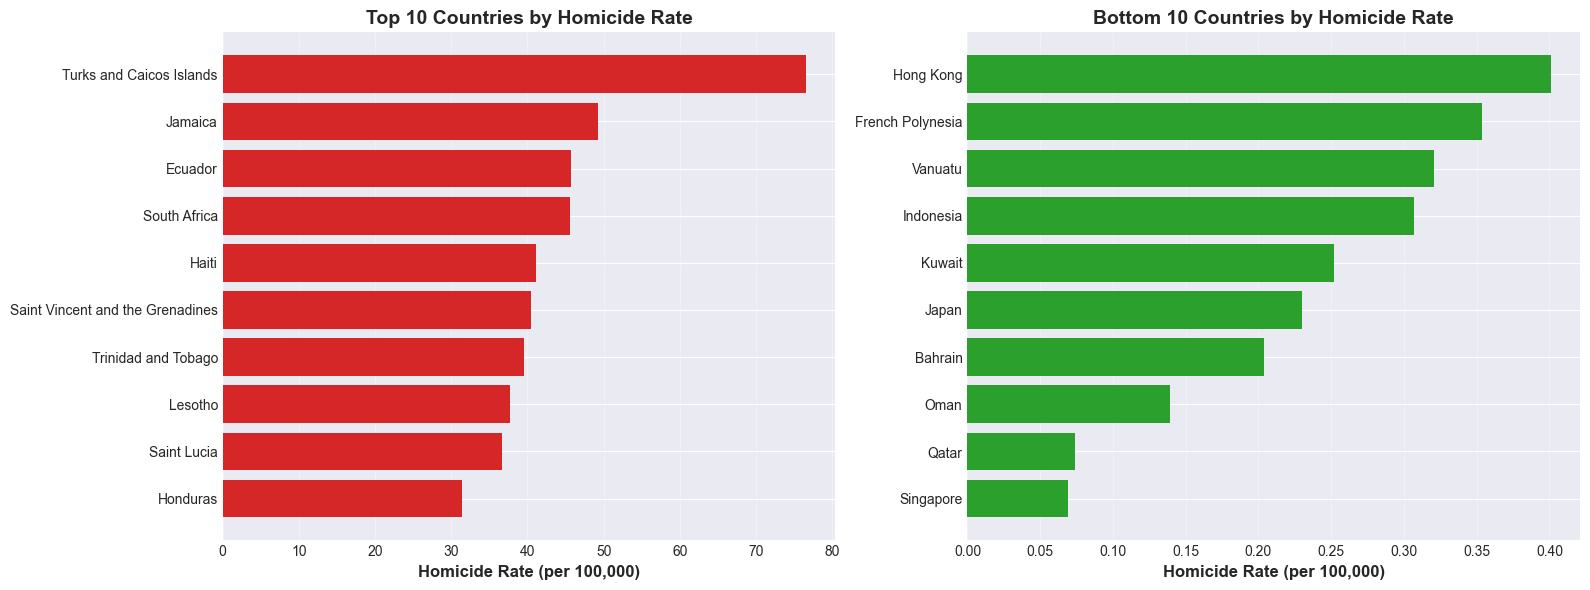


Top 10 Highest Homicide Rates:
                            name   region  homicide_rate
        Turks and Caicos Islands Americas         76.582
                         Jamaica Americas         49.299
                         Ecuador Americas         45.723
                    South Africa   Africa         45.534
                           Haiti Americas         41.152
Saint Vincent and the Grenadines Americas         40.405
             Trinidad and Tobago Americas         39.516
                         Lesotho   Africa         37.694
                     Saint Lucia Americas         36.696
                        Honduras Americas         31.442


Bottom 10 Lowest Homicide Rates:
            name  region  homicide_rate
       Hong Kong    Asia          0.401
French Polynesia Oceania          0.354
         Vanuatu Oceania          0.321
       Indonesia    Asia          0.307
          Kuwait    Asia          0.252
           Japan    Asia          0.230
         Bahrain    Asia  

In [63]:
# Filter countries with valid homicide rate data
df_with_homicide = df_final[df_final['homicide_rate'].notna()].copy()
df_with_homicide = df_with_homicide.sort_values('homicide_rate', ascending=False)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 10 highest homicide rates
top_10 = df_with_homicide.head(10)
ax1.barh(range(len(top_10)), top_10['homicide_rate'], color='#d62728')
ax1.set_yticks(range(len(top_10)))
ax1.set_yticklabels(top_10['name'], fontsize=10)
ax1.set_xlabel('Homicide Rate (per 100,000)', fontsize=12, fontweight='bold')
ax1.set_title('Top 10 Countries by Homicide Rate', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Bottom 10 lowest homicide rates
bottom_10 = df_with_homicide.tail(10)
ax2.barh(range(len(bottom_10)), bottom_10['homicide_rate'], color='#2ca02c')
ax2.set_yticks(range(len(bottom_10)))
ax2.set_yticklabels(bottom_10['name'], fontsize=10)
ax2.set_xlabel('Homicide Rate (per 100,000)', fontsize=12, fontweight='bold')
ax2.set_title('Bottom 10 Countries by Homicide Rate', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Display the data
print("\nTop 10 Highest Homicide Rates:")
print(top_10[['name', 'region', 'homicide_rate']].to_string(index=False))
print("\n\nBottom 10 Lowest Homicide Rates:")
print(bottom_10[['name', 'region', 'homicide_rate']].to_string(index=False))


### 4.2 Correlation Heatmap


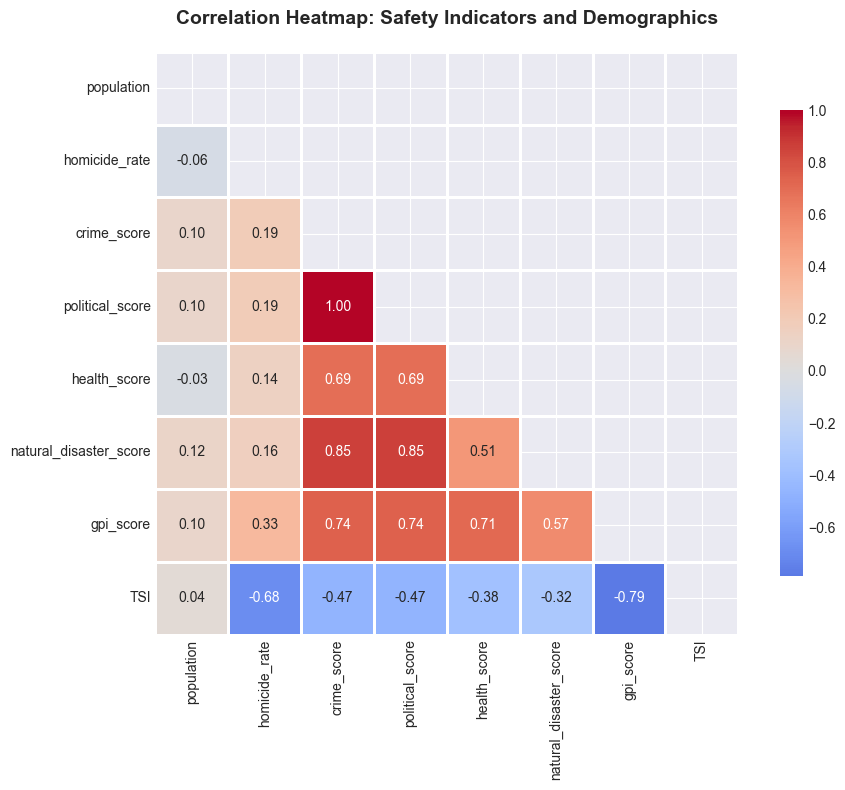

In [64]:
# Create correlation heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_data, dtype=bool))  # Mask upper triangle
sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, mask=mask)
plt.title('Correlation Heatmap: Safety Indicators and Demographics', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


### 4.3 Regional Safety Comparison


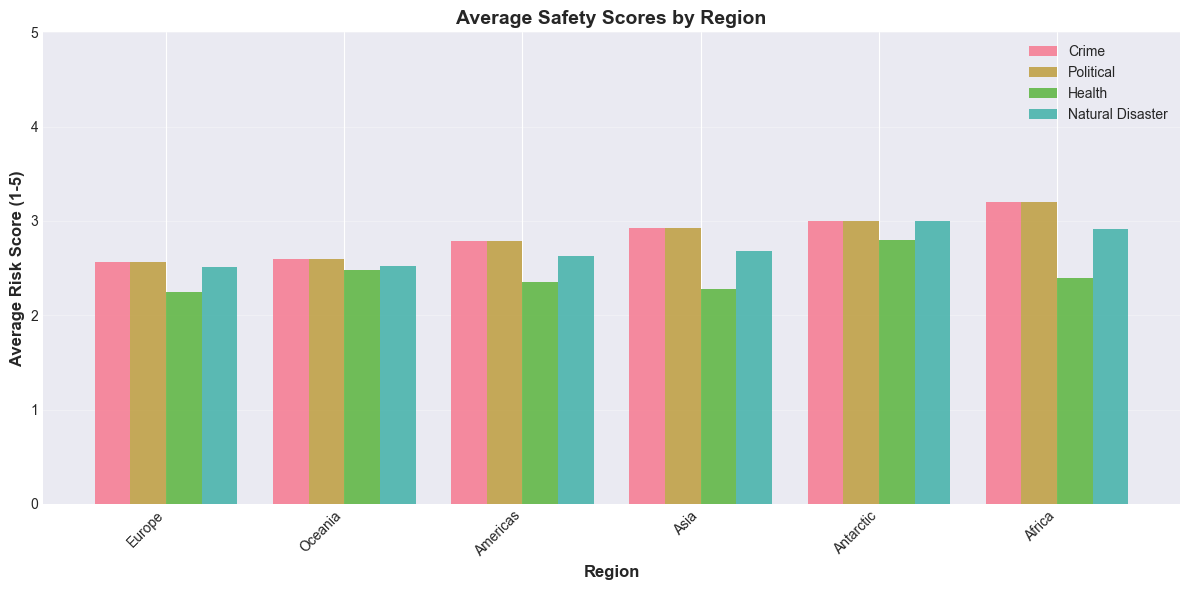

In [65]:
# Compare safety scores by region
regional_safety = df_final.groupby('region')[safety_cols].mean().sort_values('crime_score')

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(regional_safety))
width = 0.2

ax.bar(x - 1.5*width, regional_safety['crime_score'], width, label='Crime', alpha=0.8)
ax.bar(x - 0.5*width, regional_safety['political_score'], width, label='Political', alpha=0.8)
ax.bar(x + 0.5*width, regional_safety['health_score'], width, label='Health', alpha=0.8)
ax.bar(x + 1.5*width, regional_safety['natural_disaster_score'], width, label='Natural Disaster', alpha=0.8)

ax.set_xlabel('Region', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Risk Score (1-5)', fontsize=12, fontweight='bold')
ax.set_title('Average Safety Scores by Region', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(regional_safety.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 5)

plt.tight_layout()
plt.show()


### 4.4 Homicide Rate Distribution by Region


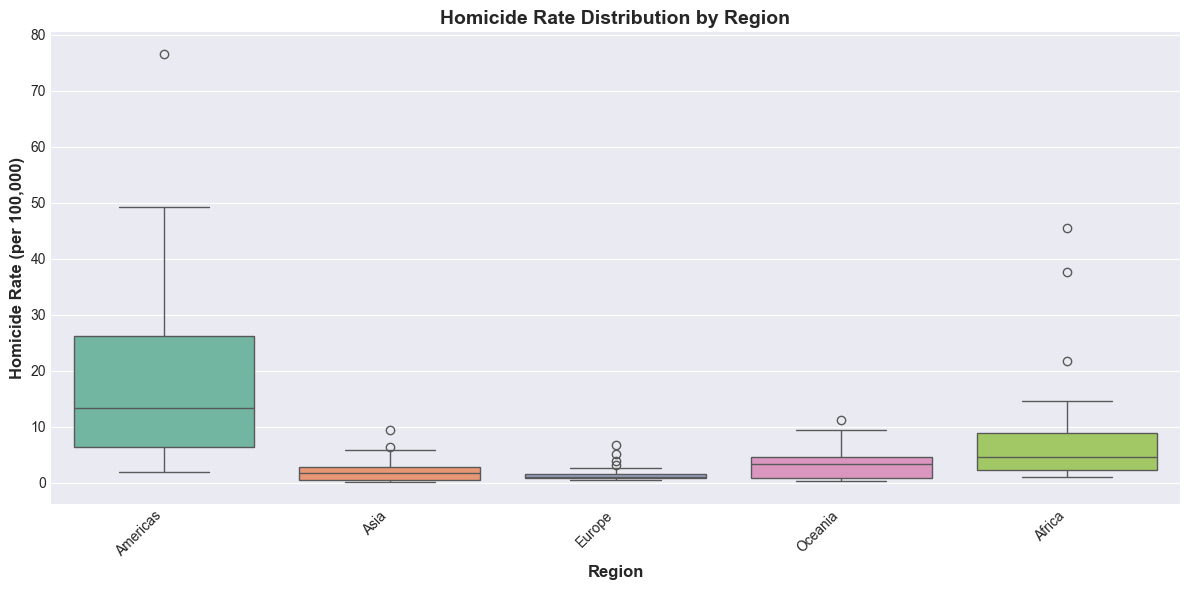

In [66]:
# Box plot of homicide rates by region
df_with_homicide_region = df_final[df_final['homicide_rate'].notna() & 
                                    (df_final['region'] != '')].copy()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_with_homicide_region, x='region', y='homicide_rate', palette='Set2')
plt.xlabel('Region', fontsize=12, fontweight='bold')
plt.ylabel('Homicide Rate (per 100,000)', fontsize=12, fontweight='bold')
plt.title('Homicide Rate Distribution by Region', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### 4.5 Radar Chart: Comparing Multiple Countries


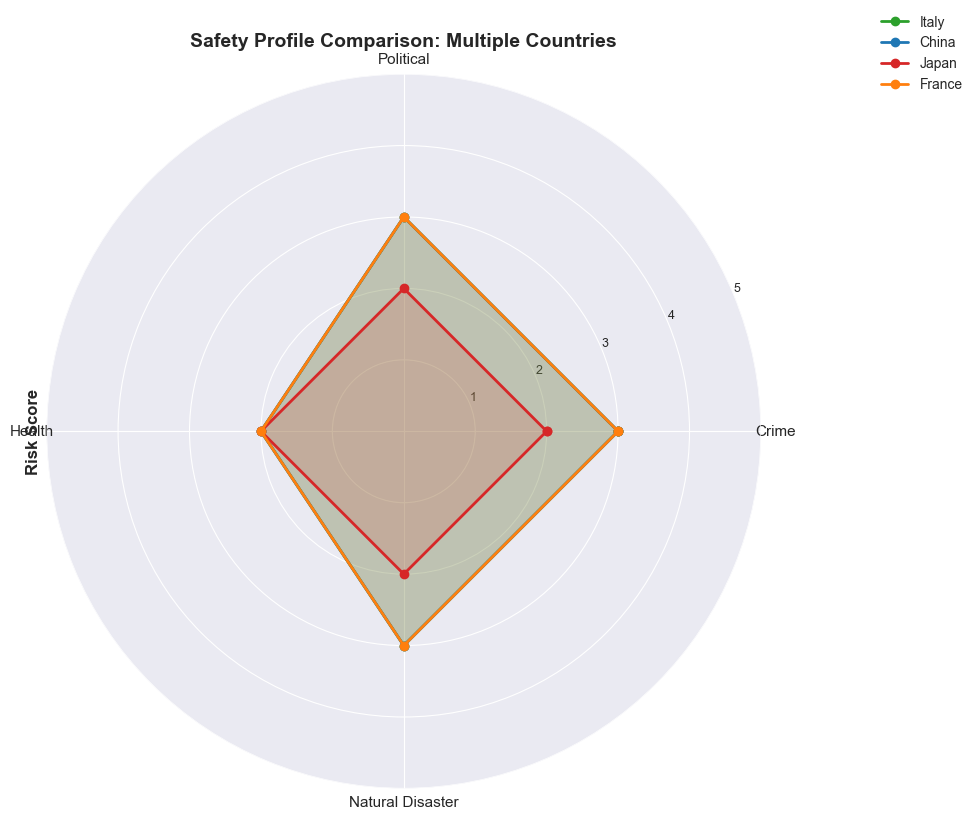

In [67]:
from math import pi

# Select countries to compare (example: France, Japan, Italy, China)
countries_to_compare = ['France', 'Japan', 'Italy', 'China']
df_compare = df_final[df_final['name'].isin(countries_to_compare)].copy()

# Prepare data for radar chart
categories = ['Crime', 'Political', 'Health', 'Natural Disaster']
N = len(categories)

# Calculate angles for each category
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Complete the circle

# Create radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, row in df_compare.iterrows():
    values = [
        row['crime_score'],
        row['political_score'],
        row['health_score'],
        row['natural_disaster_score']
    ]
    values += values[:1]  # Complete the circle
    
    ax.plot(angles, values, 'o-', linewidth=2, label=row['name'], color=colors[idx % len(colors)])
    ax.fill(angles, values, alpha=0.15, color=colors[idx % len(colors)])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim(0, 5)
ax.set_yticks([1, 2, 3, 4, 5])
ax.set_yticklabels(['1', '2', '3', '4', '5'], fontsize=9)
ax.set_ylabel('Risk Score', fontsize=12, fontweight='bold')
ax.set_title('Safety Profile Comparison: Multiple Countries', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.show()


### 4.6 Scatter Plot: Homicide Rate vs Crime Score


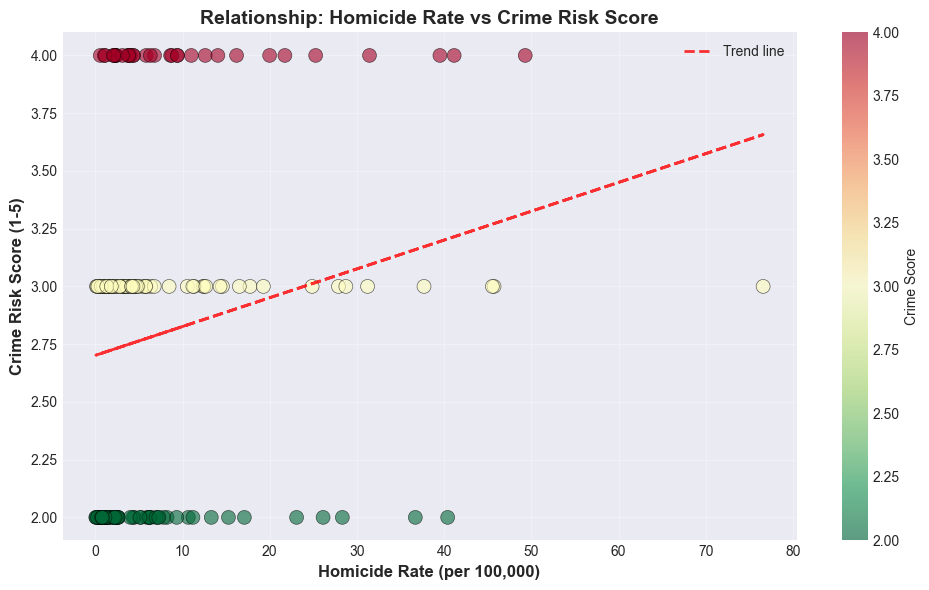


Correlation coefficient: 0.192


In [68]:
# Scatter plot comparing homicide rate with crime score
df_scatter = df_final[(df_final['homicide_rate'].notna()) & 
                       (df_final['crime_score'].notna())].copy()

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_scatter['homicide_rate'], df_scatter['crime_score'], 
                     c=df_scatter['crime_score'], cmap='RdYlGn_r', 
                     s=100, alpha=0.6, edgecolors='black', linewidth=0.5)

plt.xlabel('Homicide Rate (per 100,000)', fontsize=12, fontweight='bold')
plt.ylabel('Crime Risk Score (1-5)', fontsize=12, fontweight='bold')
plt.title('Relationship: Homicide Rate vs Crime Risk Score', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Crime Score')
plt.grid(alpha=0.3)

# Add trend line
z = np.polyfit(df_scatter['homicide_rate'], df_scatter['crime_score'], 1)
p = np.poly1d(z)
plt.plot(df_scatter['homicide_rate'], p(df_scatter['homicide_rate']), 
         "r--", alpha=0.8, linewidth=2, label=f'Trend line')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate correlation
correlation = df_scatter['homicide_rate'].corr(df_scatter['crime_score'])
print(f"\nCorrelation coefficient: {correlation:.3f}")


### 4.7 Interactive Visualizations (Plotly)

The following interactive charts let you explore TSI and its components side-by-side.


In [69]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Interactive bubble chart: Homicide vs GPI (lower raw GPI score = more peaceful)

_df = df_final.copy()

# Prepare numeric fields
_df['advisory_level_num'] = pd.to_numeric(_df.get('advisory_level'), errors='coerce')

risk_rank = {'Safe': 4, 'Moderate': 3, 'Caution': 2, 'High Risk': 1}
_df['risk_tier_rank'] = _df.get('risk_tier').map(risk_rank)

pop = pd.to_numeric(_df.get('population'), errors='coerce')
if pop.notna().any():
    pop = pop.fillna(pop.median())
else:
    pop = pd.Series([1] * len(_df), index=_df.index)

_df['bubble_size'] = np.clip(np.sqrt(pop) / 1000, 6, 40)

# Keep rows with x/y available
_df_sc = _df[_df['homicide_rate'].notna() & _df['gpi_score'].notna()].copy()

# Use an inverted GPI for plotting (more intuitive): higher = more peaceful
_gpi_raw = pd.to_numeric(_df_sc.get('gpi_score'), errors='coerce')
if _gpi_raw.notna().any():
    gpi_min = float(_gpi_raw.min())
    gpi_max = float(_gpi_raw.max())
    _df_sc['gpi_peacefulness'] = (gpi_max + gpi_min) - _gpi_raw
else:
    _df_sc['gpi_peacefulness'] = np.nan

# Quantify relationship on the plotted y
n = int(len(_df_sc))
pearson_r = float(_df_sc['homicide_rate'].corr(_df_sc['gpi_peacefulness'], method='pearson')) if n > 1 else np.nan
spearman_r = float(_df_sc['homicide_rate'].corr(_df_sc['gpi_peacefulness'], method='spearman')) if n > 1 else np.nan
print(f"Homicide vs GPI (inverted): n={n}, Pearson r={pearson_r:.3f}, Spearman ρ={spearman_r:.3f}")

# Hover customdata (robust to missing values)
_tsi = pd.to_numeric(_df_sc.get('TSI'), errors='coerce')
_hom = pd.to_numeric(_df_sc.get('homicide_rate'), errors='coerce')
_gpi_raw = pd.to_numeric(_df_sc.get('gpi_score'), errors='coerce')
_gpi_inv = pd.to_numeric(_df_sc.get('gpi_peacefulness'), errors='coerce')

hom_disp = _hom.apply(lambda v: 'N/A' if pd.isna(v) else f"{v:.2f}")
gpi_inv_disp = _gpi_inv.apply(lambda v: 'N/A' if pd.isna(v) else f"{v:.3f}")
gpi_raw_disp = _gpi_raw.apply(lambda v: 'N/A' if pd.isna(v) else f"{v:.3f}")

hover_df = pd.DataFrame(
    {
        'name': _df_sc['name'].astype(str),
        'TSI': _tsi,
        'homicide_rate_disp': hom_disp,
        'gpi_inverted_disp': gpi_inv_disp,
        'gpi_raw_disp': gpi_raw_disp,
        'advisory_level': _df_sc.get('advisory_level').astype(str),
        'risk_tier': _df_sc.get('risk_tier').astype(str),
    }
)
customdata = hover_df.to_numpy(dtype=object)

# Trend line (linear fit on log1p(x) to reduce skew impact)
x = pd.to_numeric(_df_sc['homicide_rate'], errors='coerce')
y = pd.to_numeric(_df_sc['gpi_peacefulness'], errors='coerce')
mask = x.notna() & y.notna() & (x > 0)
trend_x = None
trend_y = None
if int(mask.sum()) >= 3:
    x_fit = np.linspace(float(x[mask].min()), float(x[mask].max()), 200)
    b1, b0 = np.polyfit(np.log1p(x[mask].values), y[mask].values, 1)
    y_fit = b1 * np.log1p(x_fit) + b0
    trend_x, trend_y = x_fit, y_fit

fig = go.Figure()

# Main scatter
fig.add_trace(
    go.Scatter(
        x=_df_sc['homicide_rate'],
        y=_df_sc['gpi_peacefulness'],
        mode='markers',
        name='Countries',
        marker=dict(
            size=_df_sc['bubble_size'],
            sizemode='diameter',
            opacity=0.75,
            line=dict(width=0.5, color='black'),
            color=_df_sc['risk_tier_rank'].fillna(0),
            colorscale='Viridis',
            cmin=1,
            cmax=4,
            showscale=True,
            colorbar=dict(
                title='Color: risk_tier',
                tickmode='array',
                tickvals=[1, 2, 3, 4],
                ticktext=['High Risk', 'Caution', 'Moderate', 'Safe'],
            ),
        ),
        customdata=customdata,
        hovertemplate=(
            "<b>%{customdata[0]}</b><br>"
            "TSI: %{customdata[1]:.1f}<br>"
            "Homicide rate: %{customdata[2]}<br>"
            "GPI (inverted; higher=more peaceful): %{customdata[3]}<br>"
            "GPI (raw): %{customdata[4]}<br>"
            "Advisory level: %{customdata[5]}<br>"
            "Risk tier: %{customdata[6]}"
            "<extra></extra>"
        ),
    )
)

# Trend line trace (toggle via legend)
if trend_x is not None:
    fig.add_trace(
        go.Scatter(
            x=trend_x,
            y=trend_y,
            mode='lines',
            name='Trend (fit on log1p(x))',
            line=dict(color='black', width=2, dash='dash'),
            hoverinfo='skip',
        )
    )

# Color dropdown
color_buttons = [
    dict(
        label='Color: risk_tier',
        method='update',
        args=[
            {
                'marker.color': [_df_sc['risk_tier_rank'].fillna(0)],
                'marker.colorscale': ['Viridis'],
                'marker.cmin': [1],
                'marker.cmax': [4],
                'marker.colorbar.title': ['Color: risk_tier'],
                'marker.colorbar.tickmode': ['array'],
                'marker.colorbar.tickvals': [[1, 2, 3, 4]],
                'marker.colorbar.ticktext': [['High Risk', 'Caution', 'Moderate', 'Safe']],
            },
            {},
        ],
    ),
    dict(
        label='Color: advisory_level',
        method='update',
        args=[
            {
                'marker.color': [_df_sc['advisory_level_num']],
                'marker.colorscale': ['RdYlGn'],
                'marker.reversescale': [True],
                'marker.cmin': [1],
                'marker.cmax': [4],
                'marker.colorbar.title': ['Color: advisory_level'],
                'marker.colorbar.tickmode': ['array'],
                'marker.colorbar.tickvals': [[1, 2, 3, 4]],
                'marker.colorbar.ticktext': [['1', '2', '3', '4']],
            },
            {},
        ],
    ),
]

# Axis scale dropdown
axis_buttons = [
    dict(label='x: linear', method='relayout', args=[{'xaxis.type': 'linear'}]),
    dict(label='x: log', method='relayout', args=[{'xaxis.type': 'log'}]),
]

# Layout fixes: avoid legend/colorbar overlap and title truncation
# (Countries is the first trace added above)
fig.data[0].marker.colorbar.update(
    x=1.12,
    y=0.5,
    len=0.88,
    thickness=18,
)

fig.update_layout(
    title=dict(
        text=(
            f"Interactive Bubble: Homicide Rate vs GPI (inverted)<br>"
            f"(n={n}, Pearson r={pearson_r:.2f}, Spearman ρ={spearman_r:.2f})"
        ),
        x=0.5,
        xanchor='center',
        y=0.98,
        yanchor='top',
        pad=dict(t=8, b=8),
    ),
    xaxis_title='Homicide Rate (per 100,000)',
    yaxis_title='GPI (inverted; higher = more peaceful)',
    legend_title_text='',
    legend=dict(
        orientation='h',
        x=0.5,
        xanchor='center',
        y=-0.18,
        yanchor='top',
    ),
    updatemenus=[
        dict(type='dropdown', x=0.01, y=1.28, xanchor='left', yanchor='top', buttons=color_buttons),
        dict(type='dropdown', x=0.36, y=1.28, xanchor='left', yanchor='top', buttons=axis_buttons),
    ],
    height=650,
    margin=dict(l=60, r=190, t=185, b=105),
)

fig.show()


Homicide vs GPI (inverted): n=137, Pearson r=-0.329, Spearman ρ=-0.632


In [70]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Interactive choropleth map with a dropdown metric selector

_dfm = df_final.copy()

metrics = [
    ('TSI', 'TSI (0-100)'),
    ('homicide_norm', 'Homicide (normalized, higher = safer)'),
    ('gpi_norm', 'GPI (normalized, higher = safer)'),
    ('advisory_norm', 'Advisory (mapped to 0-100, higher = safer)'),
]

# Choose location column
use_iso3 = ('cca3' in _dfm.columns) and _dfm['cca3'].astype(str).str.len().ge(3).any()
if use_iso3:
    _dfm['location'] = _dfm['cca3'].astype(str)
    location_mode = 'ISO-3'
else:
    _dfm['location'] = _dfm['name'].astype(str)
    location_mode = 'country names'

_dfm = _dfm[_dfm['location'].notna() & (_dfm['location'].astype(str).str.len() > 0)].copy()

# Hover customdata (robust to missing values)
# We pre-format homicide/GPI strings so hover never shows raw placeholders.
_tsi = pd.to_numeric(_dfm.get('TSI'), errors='coerce')
_hom = pd.to_numeric(_dfm.get('homicide_rate'), errors='coerce')
_gpi = pd.to_numeric(_dfm.get('gpi_score'), errors='coerce')

hom_disp = _hom.apply(lambda v: 'N/A' if pd.isna(v) else f"{v:.2f}")
gpi_disp = _gpi.apply(lambda v: 'N/A' if pd.isna(v) else f"{v:.3f}")

hover_df = pd.DataFrame(
    {
        'name': _dfm['name'].astype(str),
        'TSI': _tsi,
        'homicide_rate_disp': hom_disp,
        'gpi_score_disp': gpi_disp,
        'advisory_level': _dfm.get('advisory_level').astype(str),
        'risk_tier': _dfm.get('risk_tier').astype(str),
    }
)
customdata = hover_df.to_numpy(dtype=object)

initial_col, initial_title = metrics[0]
z0 = pd.to_numeric(_dfm.get(initial_col), errors='coerce')

fig = go.Figure(
    data=[
        go.Choropleth(
            locations=_dfm['location'],
            locationmode=location_mode,
            z=z0,
            zmin=0,
            zmax=100,
            colorscale='RdYlGn',
            colorbar=dict(title='Score (0-100)'),
            customdata=customdata,
            hovertemplate=(
                "<b>%{customdata[0]}</b><br>"
                "TSI: %{customdata[1]:.1f}<br>"
                "Homicide rate: %{customdata[2]}<br>"
                "GPI score: %{customdata[3]}<br>"
                "Advisory level: %{customdata[4]}<br>"
                "Risk tier: %{customdata[5]}"
                "<extra></extra>"
            ),
        )
    ]
)

buttons = []
for col, title in metrics:
    z = pd.to_numeric(_dfm.get(col), errors='coerce')
    buttons.append(
        dict(
            label=col,
            method='update',
            args=[
                {'z': [z]},
                {'title': f'Interactive Map: {title}'}
            ],
        )
    )

fig.update_layout(
    title=f'Interactive Map: {initial_title}',
    geo=dict(showframe=False, showcoastlines=True, projection_type='natural earth'),
    updatemenus=[
        dict(
            type='dropdown',
            x=0.01,
            y=1.08,
            xanchor='left',
            yanchor='top',
            buttons=buttons,
        )
    ],
    margin=dict(l=0, r=0, t=70, b=0),
)

fig.show()


## 5. Key Findings and Insights


In [71]:
print("=== KEY FINDINGS (TSI) ===\n")

# Ensure TSI exists before proceeding
def ensure_tsi(df):
    if 'TSI' in df.columns:
        return True

    # Recompute from normalized columns if they already exist
    norm_cols = ['homicide_norm', 'gpi_norm', 'advisory_norm']
    if all(col in df.columns for col in norm_cols):
        df['TSI'] = (
            0.4 * df['homicide_norm'] +
            0.3 * df['gpi_norm'] +
            0.3 * df['advisory_norm']
        )
        return True

    # Minimal recompute from raw inputs if available
    raw_cols = ['homicide_rate', 'gpi_score', 'advisory_level']
    if all(col in df.columns for col in raw_cols):
        hom_median = df['homicide_rate'].median()
        df['homicide_filled'] = df['homicide_rate'].fillna(hom_median)

        # GPI: lower is more peaceful, so invert during normalization
        gpi_median = df['gpi_score'].median() if 'gpi_score' in df.columns else np.nan
        df['gpi_filled'] = df['gpi_score'].fillna(gpi_median)

        df['advisory_filled'] = df['advisory_level'].fillna(2.5)

        df['homicide_log'] = np.log1p(df['homicide_filled'])
        h_min, h_max = df['homicide_log'].min(), df['homicide_log'].max()
        if h_max != h_min:
            df['homicide_norm'] = 100 - ((df['homicide_log'] - h_min) / (h_max - h_min) * 100)
        else:
            df['homicide_norm'] = 50  # flat fallback when no variance

        g_min, g_max = df['gpi_filled'].min(), df['gpi_filled'].max()
        if g_max != g_min:
            df['gpi_norm'] = 100 - ((df['gpi_filled'] - g_min) / (g_max - g_min) * 100)
        else:
            df['gpi_norm'] = 50

        if 'map_advisory' not in globals():
            def map_advisory(level):
                try:
                    level = float(level)
                    if level <= 1: return 100
                    if level <= 2: return 66
                    if level <= 3: return 33
                    return 0
                except Exception:
                    return 50
        df['advisory_norm'] = df['advisory_filled'].apply(map_advisory)

        df['TSI'] = (
            0.4 * df['homicide_norm'] +
            0.3 * df['gpi_norm'] +
            0.3 * df['advisory_norm']
        )
        return True

    print("Warning: Unable to compute TSI because required fields are missing.")
    return False

tsi_ready = ensure_tsi(df_final)

# 1) Homicide extremes
hom = df_final.dropna(subset=['homicide_rate']).sort_values('homicide_rate', ascending=False)
if not hom.empty:
    hi, lo = hom.iloc[0], hom.iloc[-1]
    print(f"1. Highest homicide rate: {hi['name']} ({hi['homicide_rate']:.2f} per 100k)")
    print(f"   Lowest homicide rate: {lo['name']} ({lo['homicide_rate']:.2f} per 100k)")

# 2) Regional patterns by TSI (higher TSI = safer)
if tsi_ready:
    regional = df_final.groupby('region')['TSI'].mean().sort_values(ascending=False)
    if not regional.empty:
        print(f"\n2. Safest region (by TSI): {regional.index[0]} ({regional.iloc[0]:.2f})")
        print(f"   Riskiest region (by TSI): {regional.index[-1]} ({regional.iloc[-1]:.2f})")
else:
    print("\nWarning: Skipping TSI regional analysis because TSI is not available.")

# 3) Correlation (TSI vs Homicide)
if tsi_ready and 'homicide_rate' in df_final.columns:
    corr = df_final['TSI'].corr(df_final['homicide_rate'])
    print(f"\n3. Correlation (TSI vs Homicide): {corr:.3f}")
    if abs(corr) > 0.5:
        print("   → Strong correlation")
    else:
        print("   → Weak correlation")

# 4) Risk tier distribution (cluster-based)
if 'risk_tier' in df_final.columns:
    dist = df_final['risk_tier'].value_counts()
    print("\n4. Risk Tier Distribution:")
    for tier, cnt in dist.items():
        print(f"   {tier}: {cnt} countries ({cnt/len(df_final)*100:.1f}%)")


=== KEY FINDINGS (TSI) ===

1. Highest homicide rate: Turks and Caicos Islands (76.58 per 100k)
   Lowest homicide rate: Singapore (0.07 per 100k)

2. Safest region (by TSI): Europe (63.24)
   Riskiest region (by TSI): Americas (45.82)

3. Correlation (TSI vs Homicide): -0.683
   → Strong correlation

4. Risk Tier Distribution:
   Caution: 125 countries (50.0%)
   Moderate: 77 countries (30.8%)
   High Risk: 31 countries (12.4%)
   Safe: 17 countries (6.8%)


## 6. Export Analysis Results


In [72]:
# Export final merged dataset
df_final.to_csv('travel_safety_analysis.csv', index=False)
print("✓ Exported merged dataset to 'travel_safety_analysis.csv'")

# Export summary statistics
summary_stats = {
    'total_countries': len(df_final),
    'countries_with_homicide_data': int(df_final['homicide_rate'].notna().sum()),
    'countries_with_safety_data': int(df_final['crime_score'].notna().sum()),
    'mean_homicide_rate': float(df_final['homicide_rate'].mean()) if df_final['homicide_rate'].notna().any() else None,
    'mean_crime_score': float(df_final['crime_score'].mean()) if df_final['crime_score'].notna().any() else None,
    'regions_covered': int(df_final['region'].nunique())
}

with open('analysis_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary_stats, f, indent=2, ensure_ascii=False)

print("✓ Exported summary statistics to 'analysis_summary.json'")
print("\nSummary:")
for key, value in summary_stats.items():
    print(f"  {key}: {value}")


✓ Exported merged dataset to 'travel_safety_analysis.csv'
✓ Exported summary statistics to 'analysis_summary.json'

Summary:
  total_countries: 250
  countries_with_homicide_data: 189
  countries_with_safety_data: 250
  mean_homicide_rate: 7.386190476190475
  mean_crime_score: 2.848
  regions_covered: 6
